In [50]:
# Imports

import numpy as np
import logging; logger = logging.getLogger(__name__)


from opendrift.models.oceandrift import OceanDrift, Lagrangian3DArray
from opendrift.models.leeway import Leeway # For Search and Rescure. May not be relevant
from opendrift.models.plastdrift import PlastDrift
from opendrift.models.sedimentdrift import SedimentDrift # Looks most promising
from opendrift.models.radionuclides import Radionuclide

from opendrift.readers import reader_netCDF_CF_generic

from pprint import pprint
from opendrift.readers import reader_global_landmask

from datetime import datetime

from opendrift.models.basemodel import OpenDriftSimulation
from opendrift.elements import LagrangianArray


### Define the model

Here, we define the class *GhostNetElement*, which is supposed to represent a single ghost net in the ocean. Then, the class *GhostNetDrift* handles the simulation. <br>

As of now, I simply copied the code from `opendrift.models.sedimentdrift.SedimentDrift`. We should also check out `opendrift.models.radionnuclides.Radionnuclide` as it also incorporates diameter, density, etc. Then, the RadionNuclideDrift shows how these properties can be handled in the simulation. <br>

The most important parts here are the `variables` field in GhostNetElement, the `required_variables` field in GhostNetDrift and the `update()` function in GhostNetDrift.

In [51]:
class GhostNetElement(Lagrangian3DArray):
    variables = Lagrangian3DArray.add_variables([
        ('settled', {'dtype': np.uint8,  # 0 is active, 1 is settled
                     'units': '1',
                     'default': 0}),
        ('terminal_velocity', {'dtype': np.float32,
                               'units': 'm/s',
                               'default': -0.001})  # 1 mm/s negative buoyancy
        ])

# Differences between RadionNuclide and Sediment:
# diameter in radionuclide: BUT only needed to update terminal velocity (don't include)
# density: -------||---------


class GhostNetDrift(OceanDrift):
    """Model for sediment drift, under development
    """

    ElementType = GhostNetElement

    required_variables = {
        'x_sea_water_velocity': {'fallback': 0},
        'y_sea_water_velocity': {'fallback': 0},
        'upward_sea_water_velocity': {'fallback': 0},
        'x_wind': {'fallback': 0},
        'y_wind': {'fallback': 0},
        'sea_surface_wave_stokes_drift_x_velocity': {'fallback': 0},
        'sea_surface_wave_stokes_drift_y_velocity': {'fallback': 0},
        'sea_surface_wave_period_at_variance_spectral_density_maximum': {'fallback': 0},
        'sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment': {'fallback': 0},
        'land_binary_mask': {'fallback': None},
        'ocean_vertical_diffusivity': {'fallback': 0.02},
        'ocean_mixed_layer_thickness': {'fallback': 50},
        'sea_floor_depth_below_sea_level': {'fallback': 0},
        }

    def __init__(self, *args, **kwargs):
        """ Constructor of SedimentDrift module
        """

        super(GhostNetDrift, self).__init__(*args, **kwargs)

        # By default, sediments do not strand towards coastline
        # TODO: A more sophisticated stranding algorithm is needed
        self._set_config_default('general:coastline_action', 'previous')

        # Vertical mixing is enabled as default
        self._set_config_default('drift:vertical_mixing', True)

    def update(self):
        """Update positions and properties of sediment particles.
        """

        # Advecting here all elements, but want to soon add
        # possibility of not moving settled elements, until
        # they are resuspended. May then need to send a boolean
        # array to advection methods below
        self.advect_ocean_current()

        self.vertical_advection()

        self.advect_wind()  # Wind shear in upper 10cm of ocean

        self.stokes_drift()

        #self.vertical_mixing()  # Including buoyancy and settling

        self.resuspension()

    def bottom_interaction(self, seafloor_depth):
        """Sub method of vertical_mixing, determines settling"""
        # Elements at or below seafloor are settled, by setting
        # self.elements.moving to 0.
        # These elements will not move until eventual later resuspension.
        settling = np.logical_and(self.elements.z <= seafloor_depth, self.elements.moving==1)
        if np.sum(settling) > 0:
            logger.debug('Settling %s elements at seafloor' % np.sum(settling))
            self.elements.moving[settling] = 0

    def resuspension(self):
        """Resuspending elements if current speed > .5 m/s"""
        resuspending = np.logical_and(self.current_speed()>.5, self.elements.moving==0)
        if np.sum(resuspending) > 0:
            # Allow moving again
            self.elements.moving[resuspending] = 1
            # Suspend 1 cm above seafloor
            self.elements.z[resuspending] = self.elements.z[resuspending] + .01


In [52]:
o = GhostNetDrift(loglevel=0)

09:22:49 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
09:22:49 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
09:22:49 DEBUG   opendrift.models.basemodel:618: Adding 6 config items from basemodel
09:22:49 DEBUG   opendrift.models.basemodel:618: Adding 26 config items from basemodel
09:22:49 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.4)
09:22:49 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
09:22:49 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z


In [53]:
pprint(o.required_variables)

{'land_binary_mask': {'fallback': None},
 'ocean_mixed_layer_thickness': {'fallback': 50},
 'ocean_vertical_diffusivity': {'fallback': 0.02},
 'sea_floor_depth_below_sea_level': {'fallback': 0},
 'sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment': {'fallback': 0},
 'sea_surface_wave_period_at_variance_spectral_density_maximum': {'fallback': 0},
 'sea_surface_wave_stokes_drift_x_velocity': {'fallback': 0},
 'sea_surface_wave_stokes_drift_y_velocity': {'fallback': 0},
 'upward_sea_water_velocity': {'fallback': 0},
 'x_sea_water_velocity': {'fallback': 0},
 'x_wind': {'fallback': 0},
 'y_sea_water_velocity': {'fallback': 0},
 'y_wind': {'fallback': 0}}


### Add Readers. There are two readers of interest: 
- Generic reader that retrieves ocean data for simulating currents
- Landmask reader for land data (where ocean meets land). This file is simply 3D tensor (matrix) containing 1 where there is land and 0 where there is ocean <br>

Each reader needs a filename, that is either a local file or URL. Here I use the URL provided [here](https://opendrift.github.io/tutorial.html#import-a-specific-model-for-the-relevant-application) <br>

**They are accessed in the following manner:**

In [54]:
# Generic reader
reader_norkyst = reader_netCDF_CF_generic.Reader(
    filename='https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
)

# Landmask reader. 
reader_landmask = reader_global_landmask.Reader()

09:22:49 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
09:22:52 DEBUG   opendrift.readers.reader_netCDF_CF_generic:146: Finding coordinate variables.
09:22:52 DEBUG   opendrift.readers.reader_netCDF_CF_generic:342: Skipped variables without standard_name: ['angle', 'tke', 'ubar', 'vbar']
09:22:52 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 25 for reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be, assuming a maximum average speed of 5 m/s and time span of 1:00:00
09:22:52 DEBUG   opendrift.readers.basereader:168: Variable mapping: ['sea_floor_depth_below_sea_level'] -> ['land_binary_mask'] is not activated
09:22:52 DEBUG   opendrift.readers.basereader:168: Variable mapping: ['sea_floor_depth_below_sea_level'] -> ['land_binary_mask'] is not activated


In [55]:
o.add_reader([reader_landmask, reader_norkyst])

09:22:52 DEBUG   opendrift.models.basemodel:945: Added reader global_landmask
09:22:52 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 7 for reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be, assuming a maximum average speed of 1 m/s and time span of 1:00:00
09:22:52 DEBUG   opendrift.models.basemodel:945: Added reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be


### Seeding elements
To seed an element simply means releasing it into the ocean (for simulation). <br>

**Important:**
- If `lon` and `lat` are given as arrays of two elements, the GhostNet is dropped randomly at the line between them. Here, the radius can incorporate the uncertainty of the line's width. 
- If `time` is given as an array, then the GhostNet is dropped randomly in the timeinterval. 

In [56]:
# These are the standard arguments. 
# number GhostNet is dropped at longitude 4.3, lattitude 60 within a radius of 1000 meters. 
o.seed_elements(lon=4.5, lat=60, radius=1000, number=10, time=reader_norkyst.start_time)

In [57]:
# Inspect properties of the GhostNet dropped
o.elements_scheduled

ID: [ 1  2  3  4  5  6  7  8  9 10]
status: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
moving: 1
age_seconds: 0.0
origin_marker: 0
lon: [4.5316153 4.507174  4.517544  4.5401607 4.533473  4.4824843 4.5170336
 4.4972878 4.49815   4.5073566]
lat: [60.00129  60.013054 60.00683  60.001087 60.00398  60.002995 60.01341
 59.998158 60.00281  59.992332]
z: 0.0
wind_drift_factor: 0.02
current_drift_factor: 1.0
terminal_velocity: -0.001
settled: 0

### Configurating the simulation

We can also provide custom configurations to the simulation, that may suit GhostNets better.

In [58]:
# Parameters available to configurate:
o.list_configspec()

general:use_auto_landmask           [True] bool   A built-in GSHHG glo...
general:coastline_action            [previous] enum  ['none', 'stranding', 'previous'] None means that obje...
general:time_step_minutes           [60] float min: 0.01, max: 1440 [minutes] Calculation time ste...
general:time_step_output_minutes    [None] float min: 1, max: 1440 [minutes] Output time step, i....
seed:ocean_only                     [True] bool   If True, elements se...
seed:number                         [1] int   min: 1, max: 100000000 [1] The number of elemen...
drift:max_age_seconds               [None] float min: 0, max: inf [seconds] Elements will be dea...
drift:advection_scheme              [euler] enum  ['euler', 'runge-kutta', 'runge-kutta4'] Numerical advection ...
drift:current_uncertainty           [0] float min: 0, max: 5 [m/s] Add gaussian perturb...
drift:current_uncertainty_uniform   [0] float min: 0, max: 5 [m/s] Add gaussian perturb...
drift:horizontal_diffusivity        [0] floa

### Running the model

In [59]:
# Variables the simulation needs
o.required_variables

{'x_sea_water_velocity': {'fallback': 0},
 'y_sea_water_velocity': {'fallback': 0},
 'upward_sea_water_velocity': {'fallback': 0},
 'x_wind': {'fallback': 0},
 'y_wind': {'fallback': 0},
 'sea_surface_wave_stokes_drift_x_velocity': {'fallback': 0},
 'sea_surface_wave_stokes_drift_y_velocity': {'fallback': 0},
 'sea_surface_wave_period_at_variance_spectral_density_maximum': {'fallback': 0},
 'sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment': {'fallback': 0},
 'land_binary_mask': {'fallback': None},
 'ocean_vertical_diffusivity': {'fallback': 0.02},
 'ocean_mixed_layer_thickness': {'fallback': 50},
 'sea_floor_depth_below_sea_level': {'fallback': 0}}

In [60]:
# Hover over run to see documentation
o.run(time_step=3600, steps=1)

09:22:52 DEBUG   opendrift.models.basemodel:2529: 
------------------------------------------------------
Software and hardware:
  OpenDrift version 1.10.4
  Platform: Darwin, 21.6.0
  64.0 GB memory
  10 processors (i386)
  NumPy version 1.24.1
  SciPy version 1.10.0
  Matplotlib version 3.6.3
  NetCDF4 version 1.6.2
  Xarray version 2023.1.0
  Python version 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
------------------------------------------------------

09:22:52 DEBUG   opendrift.models.basemodel:2546: No output file is specified, neglecting export_buffer_length
09:22:52 INFO    opendrift.models.basemodel:2575: Fallback values will be used for the following variables which have no readers: 
09:22:52 INFO    opendrift.models.basemodel:2578: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
09:22:52 INFO    opendrift.models.basemodel:2578: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
09:22:52 INFO    opendrift.models.basemodel:2578: 	sea

09:22:53 DEBUG   opendrift.models.basemodel:3164: Setting up map: corners=None, fast=False, lscale=None
09:22:53 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: f, extent: (4.082484340667724, 4.941754722595214, 59.77540664672852, 60.21340866088866)..
09:22:54 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: f, extent: (4.082484340667724, 4.941754722595214, 59.77540664672852, 60.21340866088866)..
09:22:56 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: f, extent: (4.082484340667724, 4.941754722595214, 59.77540664672852, 60.21340866088866)..


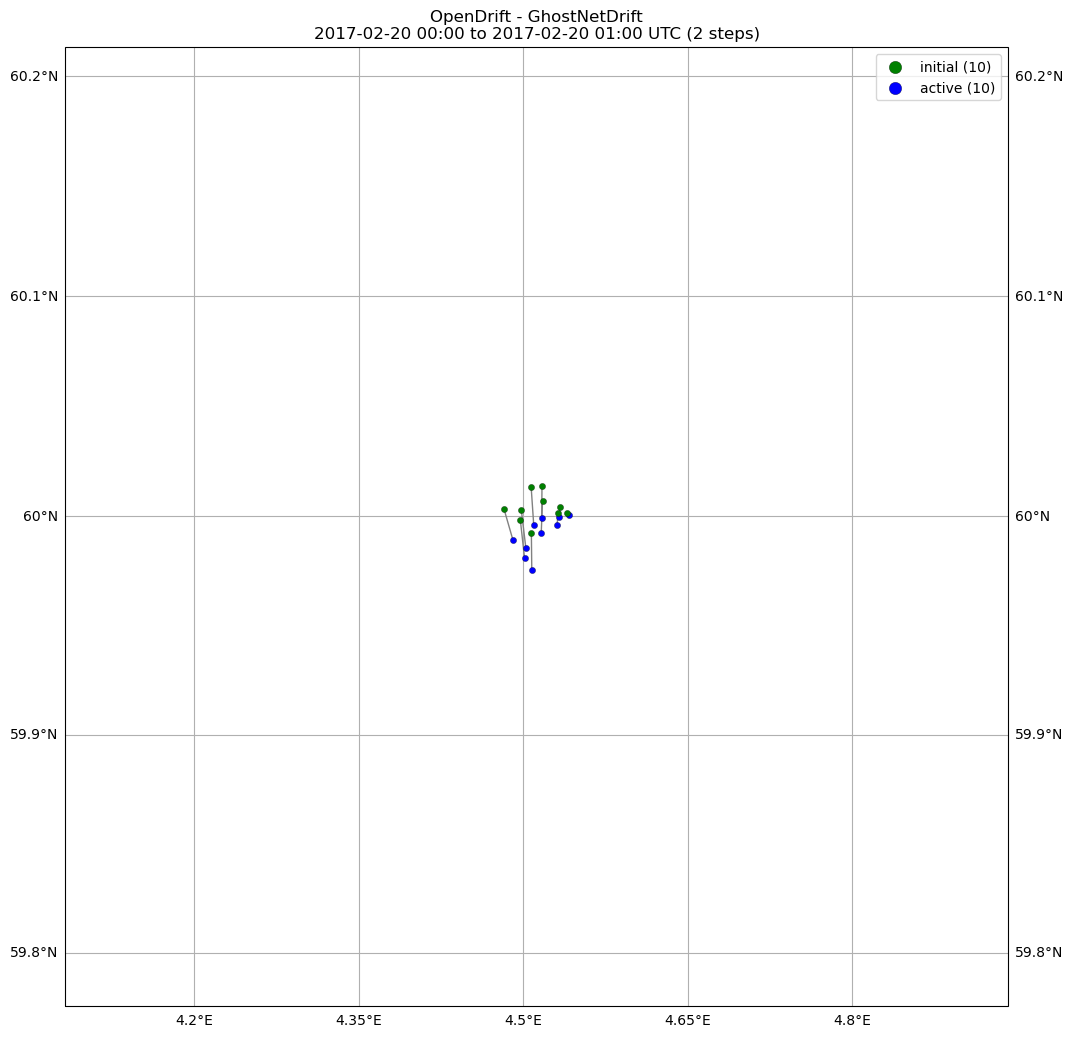

(<GeoAxesSubplot: title={'center': 'OpenDrift - GhostNetDrift\n2017-02-20 00:00 to 2017-02-20 01:00 UTC (2 steps)'}>,
 <Figure size 1079.17x1100 with 1 Axes>)

In [61]:
o.plot()

### Testing SINTEF data (not relevant ATM)

In [62]:
# Change name of time variable
import os
for file in [f'./data/aver-monthly{bool(i)*f"-{i}"}' for i in range(6)]:
    os.system(f'ncrename -v time,time_var {file}.nc {file}-xr.nc')

ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-xr.nc (y/n)? 
ncrename: ERROR nco_fl_overwrite_prm() reports 10 failed attempts to obtain valid interactive input. Assuming non-interactive shell and exiting.
ncrename: overwrite ./data/aver-monthly-1-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-1-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-1-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-1-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-1-xr.nc (y/n)? ncrename: overwrite ./data/aver-monthly-1-xr.nc (

In [63]:
norkyst = reader_netCDF_CF_generic.Reader(
    [f'./data/aver-monthly{bool(i)*f"-{i}"}-xr.nc' for i in range(6)]
)

09:22:58 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: ['./data/aver-monthly-xr.nc', './data/aver-monthly-1-xr.nc', './data/aver-monthly-2-xr.nc', './data/aver-monthly-3-xr.nc', './data/aver-monthly-4-xr.nc', './data/aver-monthly-5-xr.nc']
09:22:58 INFO    opendrift.readers.reader_netCDF_CF_generic:131: Opening files with MFDataset


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [ ]:
print(reader_netCDF_CF_generic.Reader('./data/aver-monthly-xr.nc'))

Reader: ./data/aver-monthly-xr.nc
Projection: 
  +proj=stere +lat_0=90.0 +lon_0=58.0 +lat_ts=90.0 +k_0=1.0 +x_0=2213760.0 +y_0=1878960.0 +units=m +a=6371000.0 +no_defs
Coverage: [degrees]
  xmin: 160.000000   xmax: 189600.000000   step: 160   numx: 1185
  ymin: 160.000000   ymax: 141600.000000   step: 160   numy: 885
  Corners (lon, lat):
    (  6.13,  65.09)  (  8.64,  66.35)
    (  8.32,  64.33)  ( 10.87,  65.54)
Vertical levels [m]: 
  [   -2.    -3.    -4.    -5.    -6.    -7.    -8.    -9.   -10.   -12.
   -15.   -20.   -25.   -30.   -35.   -40.   -50.   -60.   -75.  -100.
  -125.  -150.  -175.  -200.  -225.  -250.  -275.  -300.  -325.  -350.
  -375.  -400.  -425.  -450.  -475.  -500.  -525.  -550.  -575.  -600.
  -625.  -650.  -700.  -750.  -800.  -850.  -900. -1000. -1125. -1250.
 -1375. -1500. -1750. -2000. -2250. -2500. -2750. -3000.]
Available time range:
  start: None   end: None   step: None
Variables:
  depth
  gridSize



In [ ]:
print(reader_netCDF_CF_generic.Reader('./data/aver-monthly-1-xr.nc'))

17:04:31 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: ./data/aver-monthly-1-xr.nc
17:04:31 DEBUG   opendrift.readers.reader_netCDF_CF_generic:146: Finding coordinate variables.
17:04:31 DEBUG   opendrift.readers.reader_netCDF_CF_generic:163: Parsing CF grid mapping dictionary: {'grid_mapping_name': 'polar_stereographic', 'straight_vertical_longitude_from_pole': 58.0, 'horizontal_resolution': 160.0, 'latitude_of_projection_origin': 90.0, 'longitude_of_projection_origin': 58.0, 'standard_parallel': 60.0, 'origoRef': array([0., 0.]), 'semi_minor_axis': 6370000.0, 'semi_major_axis': 6370000.0, 'false_easting': 2213760.0, 'false_northing': 1878960.0, 'scale_factor_at_projection_origin': 1.0}
17:04:31 DEBUG   opendrift.readers.reader_netCDF_CF_generic:342: Skipped variables without standard_name: ['time_var', 'pressure', 'x_wind', 'y_wind', 'elevation', 'heat_flux', 'air_temperature', 'cloud_area_fraction', 'ice_thickness', 'ice_compactness', 'ice_u_velocity', 'ic

Reader: ./data/aver-monthly-1-xr.nc
Projection: 
  +proj=stere +lat_0=90.0 +lon_0=58.0 +lat_ts=90.0 +k_0=1.0 +x_0=2213760.0 +y_0=1878960.0 +units=m +a=6371000.0 +no_defs
Coverage: [degrees]
  xmin: 160.000000   xmax: 189600.000000   step: 160   numx: 1185
  ymin: 160.000000   ymax: 141600.000000   step: 160   numy: 885
  Corners (lon, lat):
    (  6.13,  65.09)  (  8.64,  66.35)
    (  8.32,  64.33)  ( 10.87,  65.54)
Vertical levels [m]: 
  [   -2.    -3.    -4.    -5.    -6.    -7.    -8.    -9.   -10.   -12.
   -15.   -20.   -25.   -30.   -35.   -40.   -50.   -60.   -75.  -100.
  -125.  -150.  -175.  -200.  -225.  -250.  -275.  -300.  -325.  -350.
  -375.  -400.  -425.  -450.  -475.  -500.  -525.  -550.  -575.  -600.
  -625.  -650.  -700.  -750.  -800.  -850.  -900. -1000. -1125. -1250.
 -1375. -1500. -1750. -2000. -2250. -2500. -2750. -3000.]
Available time range:
  start: None   end: None   step: None
Variables:
  depth
  gridSize



In [ ]:
norkyst = reader_netCDF_CF_generic.Reader(
    './data/aver-monthly-xr.nc', standard_name_mapping={'time_var': 'time'}
)

17:21:16 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: ./data/aver-monthly-xr.nc
17:21:16 DEBUG   opendrift.readers.reader_netCDF_CF_generic:146: Finding coordinate variables.
17:21:16 DEBUG   opendrift.readers.reader_netCDF_CF_generic:163: Parsing CF grid mapping dictionary: {'grid_mapping_name': 'polar_stereographic', 'straight_vertical_longitude_from_pole': 58.0, 'horizontal_resolution': 160.0, 'latitude_of_projection_origin': 90.0, 'longitude_of_projection_origin': 58.0, 'standard_parallel': 60.0, 'origoRef': array([0., 0.]), 'semi_minor_axis': 6370000.0, 'semi_major_axis': 6370000.0, 'false_easting': 2213760.0, 'false_northing': 1878960.0, 'scale_factor_at_projection_origin': 1.0}
17:21:16 DEBUG   opendrift.readers.reader_netCDF_CF_generic:342: Skipped variables without standard_name: ['pressure', 'x_wind', 'y_wind', 'elevation', 'heat_flux', 'air_temperature', 'cloud_area_fraction', 'ice_thickness', 'ice_compactness', 'ice_u_velocity', 'ice_v_velocity',

In [ ]:
reader_norkyst.variable_mapping

{'sea_floor_depth_below_sea_level': 'h',
 'latitude': 'lat',
 'longitude': 'lon',
 'x_wind': 'Uwind',
 'y_wind': 'Vwind',
 'sea_water_salinity': 'salinity',
 'sea_water_temperature': 'temperature',
 'x_sea_water_velocity': 'u',
 'eastward_sea_water_velocity': 'u_eastward',
 'y_sea_water_velocity': 'v',
 'northward_sea_water_velocity': 'v_northward',
 'upward_sea_water_velocity': 'w',
 'sea_surface_elevation': 'zeta'}

In [ ]:
from netCDF4 import Dataset

ds = Dataset('./data/aver-monthly.nc')

type(ds.dimensions.values())

dims = ds.dimensions.values()
time = dims.mapping['time']

In [ ]:
time

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 3

In [ ]:
ds['time']

<class 'netCDF4._netCDF4.Variable'>
int32 time(time, dummySampleDim)
unlimited dimensions: time
current shape = (3, 6)
filling on, default _FillValue of -2147483647 used

In [ ]:
vars = ds.variables.values()
vars

dict_values([<class 'netCDF4._netCDF4.Variable'>
int32 time(time, dummySampleDim)
unlimited dimensions: time
current shape = (3, 6)
filling on, default _FillValue of -2147483647 used, <class 'netCDF4._netCDF4.Variable'>
int32 grid_mapping()
    grid_mapping_name: polar_stereographic
    straight_vertical_longitude_from_pole: 58.0
    horizontal_resolution: 160.0
    latitude_of_projection_origin: 90.0
    longitude_of_projection_origin: 58.0
    standard_parallel: 60.0
    origoRef: [0. 0.]
    semi_minor_axis: 6370000.0
    semi_major_axis: 6370000.0
    false_easting: 2213760.0
    false_northing: 1878960.0
    scale_factor_at_projection_origin: 1.0
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used, <class 'netCDF4._netCDF4.Variable'>
float32 LayerDepths(zc)
    units: m
    standard_name: cell_thickness
unlimited dimensions: 
current shape = (58,)
filling on, default _FillValue of 9.969209968386869e+36 used, <class 'netCDF4._netCDF4.Variabl

In [ ]:
reader_norkyst = reader_netCDF_CF_generic.Reader(
    'https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
)
print(reader_norkyst)

17:26:10 INFO    opendrift.readers.reader_netCDF_CF_generic:129: Opening dataset: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
17:26:20 DEBUG   opendrift.readers.reader_netCDF_CF_generic:146: Finding coordinate variables.
17:26:20 DEBUG   opendrift.readers.reader_netCDF_CF_generic:342: Skipped variables without standard_name: ['angle', 'tke', 'ubar', 'vbar']
17:26:20 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 25 for reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be, assuming a maximum average speed of 5 m/s and time span of 1:00:00
17:26:20 DEBUG   opendrift.readers.basereader:168: Variable mapping: ['sea_floor_depth_below_sea_level'] -> ['land_binary_mask'] is not activated


Reader: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
Projection: 
  +proj=stere +ellps=WGS84 +lat_0=90.0 +lat_ts=60.0 +x_0=3192800 +y_0=1784000 +lon_0=70
Coverage: [degrees]
  xmin: 0.000000   xmax: 2080800.000000   step: 800   numx: 2602
  ymin: 0.000000   ymax: 720800.000000   step: 800   numy: 902
  Corners (lon, lat):
    ( -1.58,  58.50)  ( 23.71,  75.32)
    (  9.19,  55.91)  ( 38.06,  70.03)
Vertical levels [m]: 
  [   -0.    -3.   -10.   -15.   -25.   -50.   -75.  -100.  -150.  -200.
  -250.  -300.  -500. -1000. -2000. -3000.]
Available time range:
  start: 2017-02-20 00:00:00   end: 2023-01-30 00:00:00   step: 1:00:00
    52081 times (3216 missing)
Variables:
  sea_floor_depth_below_sea_level
  latitude
  longitude
  x_wind
  y_wind
  sea_water_salinity
  sea_water_temperature
  x_sea_water_velocity
  eastward_sea_water_velocity
  y_sea_water_velocity
  northward_sea_water_velocity
  upward_sea_water_velocity
  sea_surface_elevation



In [ ]:
reader_norkyst.variables

['sea_floor_depth_below_sea_level',
 'latitude',
 'longitude',
 'x_wind',
 'y_wind',
 'sea_water_salinity',
 'sea_water_temperature',
 'x_sea_water_velocity',
 'eastward_sea_water_velocity',
 'y_sea_water_velocity',
 'northward_sea_water_velocity',
 'upward_sea_water_velocity',
 'sea_surface_elevation']

In [ ]:
from datetime import datetime, timedelta
from opendrift.models.shipdrift import ShipDrift

o = ShipDrift()
o.add_readers_from_list(
    ['https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be']
)
#o.disable_vertical_motion()
o.seed_elements(lon=4.85, lat=60, time=datetime.now(), number=10000, radius=1000)

o.run(duration=timedelta(hours=72))
o.animation(filename='animation.mp4')

17:48:42 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
17:48:42 DEBUG   opendrift.models.basemodel:618: Adding 10 config items from basemodel
17:48:42 DEBUG   opendrift.models.basemodel:618: Adding 18 config items from basemodel
17:48:42 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.4)
17:48:42 DEBUG   opendrift.models.basemodel:618: Adding 1 config items from shipdrift
17:48:42 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:orientation
17:48:42 DEBUG   opendrift.readers.reader_lazy:32: Delaying initialisation of LazyReader: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
17:48:42 DEBUG   opendrift.models.basemodel:945: Added reader LazyReader: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
17:48:42 DEBUG   opendrift.models.basemodel:2529: 
------------------------------------------------------
Software and hardware:
  OpenDrift version 1.10.4
  Pla